# Evolution, répartition et prévision du nombre de points de recharge

In [32]:
#Import des principales librairies Python
import pandas as pd
import plotly.figure_factory as ff
import requests
import seaborn as sns
from prophet import Prophet
from matplotlib import pyplot as plt
%matplotlib inline

## Traitement des données sur les points de charge

Ce jeu de données présente le nombre total de points de charge en France continentale : [Dataset ENEDIS](https://data.enedis.fr/explore/dataset/nombre-total-de-points-de-charge/information/?dataChart=eyJxdWVyaWVzIjpbeyJjaGFydHMiOlt7InR5cGUiOiJjb2x1bW4iLCJmdW5jIjoiU1VNIiwieUF4aXMiOiJzb2NpZXRlIiwic2NpZW50aWZpY0Rpc3BsYXkiOnRydWUsImNvbG9yIjoiI0E2QjlFNCJ9LHsidHlwZSI6ImNvbHVtbiIsImZ1bmMiOiJTVU0iLCJ5QXhpcyI6InBhcnRpY3VsaWVyIiwic2NpZW50aWZpY0Rpc3BsYXkiOnRydWUsImNvbG9yIjoiI0ZDOEQ2MiJ9LHsidHlwZSI6ImNvbHVtbiIsImZ1bmMiOiJTVU0iLCJ5QXhpcyI6ImFjY2Vzc2libGVfYXVfcHVibGljIiwic2NpZW50aWZpY0Rpc3BsYXkiOnRydWUsImNvbG9yIjoiIzY2QzJBNSJ9XSwieEF4aXMiOiJ0cmltZXN0cmUiLCJtYXhwb2ludHMiOjUwLCJzb3J0IjoiIiwic3RhY2tlZCI6Im5vcm1hbCIsImNvbmZpZyI6eyJkYXRhc2V0Ijoibm9tYnJlLXRvdGFsLWRlLXBvaW50cy1kZS1jaGFyZ2UiLCJvcHRpb25zIjp7fX19XSwidGltZXNjYWxlIjoiIiwic2luZ2xlQXhpcyI6dHJ1ZSwiZGlzcGxheUxlZ2VuZCI6dHJ1ZSwiYWxpZ25Nb250aCI6dHJ1ZX0%3D&sort=-trimestre).

Les points de charge sont matérialisés par un socle de prise sur lequel un véhicule électrique peut potentiellement se brancher. Une borne de recharge peut comporter un ou plusieurs points de charge. Les données présentées segmentent les points de charge en trois typologies :

- Les points de charge « accessible au public » correspondent aux points de charge accessibles dans les commerces (supermarché, concession automobile…), parking, sites publics ou stations en voirie.
- Les points de charge « particulier » sont des points de charges privés localisés dans le résidentiel collectif (immeubles, copropriétés…) ou individuel (pavillons).
- Les points de charge « société » sont des points de charge privés localisés dans les sociétés et réservés à l’activité de la société ou à la recharge des véhicules électriques des employés.

Le jeu de données a été élaboré par Enedis à partir de ses données propres combinées avec certaines données externes, issues des sociétés Girève et AAA Data. Les données sur les points de charge « particulier » et « société » sont une reconstitution de l’existant construite par Enedis sur la base d’hypothèses. Ces hypothèses s’appuient sur l’évolution du marché du véhicule électrique.

In [25]:
irve_type = pd.read_csv('raw_data/nombre-total-de-points-de-charge.csv', sep=';')
irve_type = irve_type.sort_values('Trimestre').reset_index(drop=True)
irve_type

,Trimestre,Accessible au public,Particulier,Société
0,2015 T1,8478,25638,34746
1,2015 T2,10086,29662,37933
2,2015 T3,10928,32278,38681
3,2015 T4,11113,37448,42891
4,2016 T1,12830,43284,48013
5,2016 T2,13861,48412,52015
6,2016 T3,12859,52052,55309
7,2016 T4,16220,57039,59408
8,2017 T1,17423,62957,63757
9,2017 T2,19750,68509,68930


In [26]:
#Calcul des évolutions en % entre chaque trimestre

irve_type['%Public'] = irve_type['Accessible au public'].pct_change().fillna(0)
irve_type['%Particulier'] = irve_type['Particulier'].pct_change().fillna(0)
irve_type['%Société'] = irve_type['Société'].pct_change().fillna(0)



In [29]:
from typing import Tuple

trimestre_mapping={'T1' : '31-03',
                    'T2' : '30-06',
                    'T3' : '30-09',
                    'T4' : '31-12'}

def transformation_trimestre(couple_annee_trimestre:Tuple[str,str]):
    """Retourne le dernier jour du trimestre en format string à partir de l'année et du trimestre."""
    return couple_annee_trimestre[0] + '-'+ trimestre_mapping[couple_annee_trimestre[1]]

irve_type['time']=irve_type['Trimestre'].apply(lambda x: transformation_trimestre(x.split()))
irve_type['time'] = pd.to_datetime(irve_type['time'], format="%Y-%d-%m")

irve_type

,Trimestre,Accessible au public,Particulier,Société,%Public,%Particulier,%Société,time
0,2015 T1,8478,25638,34746,0.000000,0.000000,0.000000,2015-03-31
1,2015 T2,10086,29662,37933,0.189667,0.156955,0.091723,2015-06-30
2,2015 T3,10928,32278,38681,0.083482,0.088194,0.019719,2015-09-30
3,2015 T4,11113,37448,42891,0.016929,0.160171,0.108839,2015-12-31
4,2016 T1,12830,43284,48013,0.154504,0.155843,0.119419,2016-03-31
5,2016 T2,13861,48412,52015,0.080359,0.118473,0.083352,2016-06-30
6,2016 T3,12859,52052,55309,-0.072289,0.075188,0.063328,2016-09-30
7,2016 T4,16220,57039,59408,0.261373,0.095808,0.074111,2016-12-31
8,2017 T1,17423,62957,63757,0.074168,0.103754,0.073206,2017-03-31
9,2017 T2,19750,68509,68930,0.133559,0.088187,0.081136,2017-06-30


In [30]:
#Affichage des types de données /Variables
irve_type.dtypes

Trimestre                       object
Accessible au public             int64
Particulier                      int64
Société                          int64
%Public                        float64
%Particulier                   float64
%Société                       float64
time                    datetime64[ns]
dtype: object

Text(0, 0.5, 'Number of points')

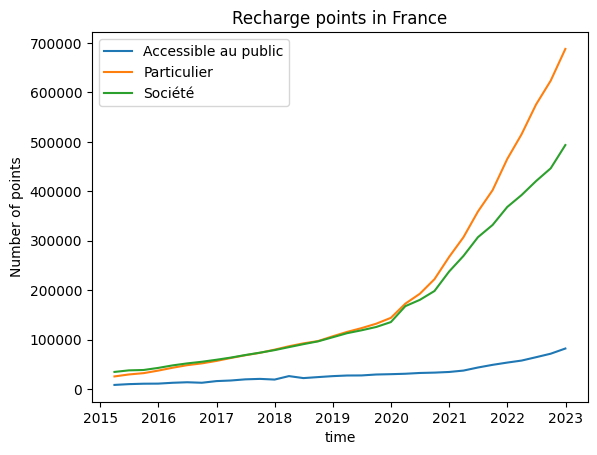

In [44]:
ax=sns.lineplot(data=irve_type, x="time", y="Accessible au public", label="Accessible au public")
sns.lineplot(data=irve_type, x="time", y="Particulier",label="Particulier")
sns.lineplot(data=irve_type, x="time", y="Société",label="Société")
ax.set(title='Recharge points in France')
ax.set_ylabel("Number of points")


In [45]:
#Analyse des valeurs manquantes du jeu de données 
irve_type.isna().any()

Trimestre               False
Accessible au public    False
Particulier             False
Société                 False
%Public                 False
%Particulier            False
%Société                False
time                    False
dtype: bool

In [46]:
#Analyse des valeurs doublons du jeu de données 
irve_type.duplicated().any()

False

## Traitement des données sur les bornes de recharge pour vehicules electriques (IRVE)


Dans le but de constituer un répertoire national des Infrastructures de recharge pour véhicules électriques (IRVE), ouvert et accessible à tous, les collectivités locales porteuses d’un projet d’installation d’IRVE doivent, au fur et à mesure de la mise en service des stations, publier sur la plateforme data.gouv.fr les données statiques relatives à la localisation et aux caractéristiques techniques de ces installations selon les modalités définies dans l’arrêté du 4 mai 2021.
Etalab consolide l'ensemble des jeux de données produits par les différents acteurs territoriaux sur un jeu de donnée consolidé. Celui-ci a pour objectif d'être le plus exhaustif possible et ambitionne de regrouper l'ensemble des bornes IRVE françaises. Un document décrivant l'ensemble des datasources utilisées pour cette consolidation peut être consulté sur la page data.gouv de la datasource.

[Datasource data.gouv](https://www.data.gouv.fr/fr/datasets/fichier-consolide-des-bornes-de-recharge-pour-vehicules-electriques/)


In [49]:
irve = pd.read_csv('raw_data/consolidation-etalab-irve.csv', sep=',', on_bad_lines='skip')
display(irve.shape)
irve

(55320, 50)

,nom_amenageur,siren_amenageur,contact_amenageur,nom_operateur,contact_operateur,telephone_operateur,nom_enseigne,id_station_itinerance,id_station_local,nom_station,...,last_modified,datagouv_dataset_id,datagouv_resource_id,datagouv_organization_or_owner,consolidated_longitude,consolidated_latitude,consolidated_code_postal,consolidated_commune,consolidated_is_lon_lat_correct,consolidated_is_code_insee_verified
0,ELECTRA,891624884.0,help@electra.com,ELECTRA,help@electra.com,NaN,ELECTRA,FRELCPBLOHM,NaN,Blotzheim - Hôtel Mercure Bâle Mulhouse Aéroport,...,2023-03-28T05:05:10.757000+00:00,623ca46c13130c3228abd018,a06bc4fc-f695-4ac6-ab81-562a30610fc2,electra,7.502904,47.608214,68730.0,Blotzheim,True,True
1,ELECTRA,891624884.0,help@electra.com,ELECTRA,help@electra.com,NaN,ELECTRA,FRELCPECUSM,NaN,Écully - Smart Lyon Écully,...,2023-03-28T05:05:10.757000+00:00,623ca46c13130c3228abd018,a06bc4fc-f695-4ac6-ab81-562a30610fc2,electra,4.783111,45.785651,69130.0,Écully,True,True
2,ELECTRA,891624884.0,help@electra.com,ELECTRA,help@electra.com,NaN,ELECTRA,FRELCPSBARS,NaN,Saint-Barthélemy-d'Anjou - RS Parc,...,2023-03-28T05:05:10.757000+00:00,623ca46c13130c3228abd018,a06bc4fc-f695-4ac6-ab81-562a30610fc2,electra,-0.502617,47.481716,49124.0,Saint-Barthélemy-d'Anjou,True,True
3,ELECTRA,891624884.0,help@electra.com,ELECTRA,help@electra.com,NaN,ELECTRA,FRELCPSBARS,NaN,Saint-Barthélemy-d'Anjou - RS Parc,...,2023-03-28T05:05:10.757000+00:00,623ca46c13130c3228abd018,a06bc4fc-f695-4ac6-ab81-562a30610fc2,electra,-0.502617,47.481716,49124.0,Saint-Barthélemy-d'Anjou,True,True
4,ELECTRA,891624884.0,help@electra.com,ELECTRA,help@electra.com,NaN,ELECTRA,FRELCPSBARS,NaN,Saint-Barthélemy-d'Anjou - RS Parc,...,2023-03-28T05:05:10.757000+00:00,623ca46c13130c3228abd018,a06bc4fc-f695-4ac6-ab81-562a30610fc2,electra,-0.502617,47.481716,49124.0,Saint-Barthélemy-d'Anjou,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55315,EVE CAR PLUG,879689750.0,contact@evecarplug.com,CHARGEPOLY,operator@chargepoly.com,0788984775,CHARGEPOLY,FRCHAPCL667TZRR31386098QO29VPVB0N,cl667tzrr31386098qo29vpvb0n,INDIAN MOTORCYCLE,...,2023-03-27T09:59:13.342000+00:00,616460fc554a323e04390335,da35da16-5ce7-4f8c-98f8-dc42395953f4,chargepoly,3.148290,45.734570,NaN,NaN,False,False
55316,MA Borne Auto,880217922.0,e.barre@maborneauto.com,ma Borne Auto,e.barre@maborneauto.com,0361626161,DACIA RONCQ,Non concerné,01FHWQ8RECFE028717E5Y5123P,DACIA RONCQ,...,2023-03-27T09:59:12.498000+00:00,6166c7d36f8323ae8d7edd8c,77d9ef46-cf74-410b-92fc-d8a2e77eb55c,ma-borne-auto,3.131541,50.739700,59223.0,Roncq,True,True
55317,Societe Ouest Location,323873174.0,Axel.peigne@ouest-location.fr,Freshmile SAS,exploitation@freshmile.com,369246732,Freshmile,FRFR1EGYTZ,NaN,"Ouest Location, Saint Herblain",...,2023-03-27T09:59:12.271000+00:00,641d9b5ab1593d45908a1f29,0fbd39a7-8f37-414e-a57c-353e7d9437f8,herve-thermique,-1.633379,47.230062,44800.0,Saint-Herblain,True,True
55318,Societe Ouest Location,323873174.0,Axel.peigne@ouest-location.fr,Freshmile SAS,exploitation@freshmile.com,369246732,Freshmile,FRFR1EGYTZ,NaN,"Ouest Location, Saint Herblain",...,2023-03-27T09:59:12.271000+00:00,641d9b5ab1593d45908a1f29,0fbd39a7-8f37-414e-a57c-353e7d9437f8,herve-thermique,-1.633379,47.230062,44800.0,Saint-Herblain,True,True


In [52]:
list(irve.nom_amenageur.unique())

['ELECTRA',
 'ARCACHON',
 'GARENNE',
 'FLEX-E',
 'GRAND NANCY',
 'MOBIVE - SDEER 17',
 'SIGEIF',
 'MOBIVE - TE 47',
 'CPS',
 'IZIVIA EXPRESS',
 'MOBIVE - SYDEC 40',
 'AVIA TD',
 'IZIVIA FMET 1',
 'UNIBAIL',
 'LEVAPARC',
 'MOBIVE - SEHV87',
 'OUEST CHARGE - 22',
 'WIIIZ',
 'SIXT',
 'MOBIVE - FDEE 19',
 'OUEST CHARGE - 29',
 'MOBIVE - SDEG 16',
 'MOBIVE - SDEPA 64',
 'OUEST CHARGE - 35',
 'SYDER',
 'AVIA PICOTY',
 'MOBIVE - SDE 24',
 'RT78',
 'MAMP',
 'SHELL',
 'ZENPARK',
 'SDESM',
 'GRSE GARAGE MARINIERE',
 'SCEA LES FUIES ',
 'SCEA LES FUIES',
 'STARTERRE',
 "LUMI'IN",
 'Hôtel Restaurant Campanile Nogent-sur-Marne',
 'Résidence Les Calanques',
 'Hotel saint Alban',
 '1PACTE',
 'Villa Primerose',
 'MAZDA CHALON S.SAONE - GROUPE GUILLET',
 'PAROT AUTOMOTIVE - MAZDA BRIVE ',
 'Aubade - Comptoir des Fers',
 'Aubade - Comptoir des Fer',
 'SCI LE PARC MILLESIME',
 'Suraya',
 'WeeCharge',
 'GCA CAEN ',
 'GCA CAEN',
 'Green Technologie',
 'MA BORNE AUTO',
 'DPA -MAZDA MONTELIMAR',
 'AUTO SPRIN

In [53]:
irve.isna().sum()

nom_amenageur                           3144
siren_amenageur                        14488
contact_amenageur                      14705
nom_operateur                           3624
contact_operateur                          0
telephone_operateur                     6860
nom_enseigne                               0
id_station_itinerance                      0
id_station_local                       26015
nom_station                                0
implantation_station                       0
adresse_station                            0
code_insee_commune                     16140
coordonneesXY                              0
nbre_pdc                                   0
id_pdc_itinerance                          0
id_pdc_local                           25927
puissance_nominale                         0
prise_type_ef                              0
prise_type_2                               0
prise_type_combo_ccs                       0
prise_type_chademo                         0
prise_type

Le premier point de contrôle passe par la recherche d'éventuels doublons. Notons que le contexte métier nécessite de la rigueur dans l'interprétation de certaines variables, l'amalgame entre station, borne et point de charge est régulièrement rencontré. Donc, "id_station" n'est pas le sous-ensemble le plus approprié à l'identification de doublons, une station de recharge peut avoir plusieurs points de charge, et l'identifiant ne tient pas compte du point de charge. Notons que "id_pdc_itinerance" permet d'obtenir des identifiants uniques pouvant cette fois-ci être pris comme sous-ensemble.

In [54]:
columns=irve.columns
for col in columns:
    duplicate_sum=irve[col].duplicated().sum()
    print(col, duplicate_sum)

nom_amenageur 52772
siren_amenageur 54134
contact_amenageur 54767
nom_operateur 55076
contact_operateur 55038
telephone_operateur 54953
nom_enseigne 53822
id_station_itinerance 36594
id_station_local 44396
nom_station 39770
implantation_station 55315
adresse_station 38728
code_insee_commune 50101
coordonneesXY 37997
nbre_pdc 55269
id_pdc_itinerance 11731
id_pdc_local 27253
puissance_nominale 55232
prise_type_ef 55312
prise_type_2 55312
prise_type_combo_ccs 55312
prise_type_chademo 55313
prise_type_autre 55313
gratuit 55311
paiement_acte 55312
paiement_cb 55312
paiement_autre 55311
tarification 55103
condition_acces 55318
reservation 55313
horaires 54751
accessibilite_pmr 55316
restriction_gabarit 55165
station_deux_roues 55314
raccordement 55317
num_pdl 52579
date_mise_en_service 53063
observations 55170
date_maj 54672
cable_t2_attache 55312
last_modified 54523
datagouv_dataset_id 54668
datagouv_resource_id 54523
datagouv_organization_or_owner 55111
consolidated_longitude 38090
consoli

**TO DISCUSS IF USE OTHER DATA. Remarque de nalron:**

Notons que le fichier mis à disposition sur le site data.gouv.fr annonce plusieurs consolidations selon les années 2014 à 2016 et 2018. Attention, quelques opérateurs comme Tesla, Nissan, Auchan, etc… ne sont plus observés dans la version de juin 2020 et même depuis plusieurs mois. Non pas parce que ces stations de recharge ont été retirées, mais par logique d'uniformisation selon une charte d'utilisation "Fichiers à destination des aménageurs et opérateurs publics et privés d'infrastructures de recharge pour véhicules électriques" consultable sur [data.gouv.fr](https://www.data.gouv.fr/fr/datasets/fichiers-pour-les-infrastructures-de-recharge-de-vehicules-electriques/)

<em>Le décret 2017-26 du 12 janvier 2017 fixe les exigences requises pour la configuration des points de recharge à publier sur un nouveau fichier désormais en CSV. L'aménageur, ou l'opérateur désigné le cas échéant, prend les mesures appropriées pour que ces données soient en permanence tenues à jour et rendues publiques sur data.gouv.fr</em>

<u>Dans le cadre de l'étude, les opérateurs (ou principaux opérateurs) identifiés comme manquants seront réintégrés dans l'échantillon.</u>

In [58]:
#Combien de stations de recharge en Mars 2023
irve.id_station_itinerance.nunique()

18726

In [59]:
irve.id_station_local.nunique()

10923

In [60]:
#Combien de bornes de recharge (en anglais Charging Station) en Mars 2023
irve.id_pdc_itinerance.nunique()

43589

**Combien de points de charge en France?**
Selon la définition de l'AFIREV, le point de charge représente le nombre d'emplacements individuels permettant le stationnement du véhicule pendant le temps de charge, donc le nombre de prises de la borne. Le jeu de données `irve` ne permet pas de le quantifier directement, malgré la présence d'une variable 'nbre_pdc' qui ne représente que la borne et non le nombre de prises. Il est nécessaire d'enrichir les données par une estimation des prises de chacune des bornes, ce calcul pourra être réalisé à l'aide de la variable 'type_prise'. <u>Cet enrichissement sera fait plus tard après intégration des opérateurs manquants.</u>

Les articles suivants permettent de se faire une idée de l'évolution du nombre de points de charge en France en 2022 et 2023 : 

**Article de Février 2023:** [Source](https://www.tressol-chabrier.com/actualites/Le+futur+de+l%E2%80%99automobile/Voiture%2B%25C3%25A9lectrique%2B%253A%2B85%2B284%2Bpoints%2Bde%2Brecharge%2Bdisponibles%2Ben%2BFrance-107) 

"85 284, c’est le nombre de points de recharge ouverts au public au 31 janvier 2023. Il est donc aujourd’hui de plus en plus facile de recharger sa voiture électrique. Il s’agit d’une évolution de + 57 % en un an. Si ces efforts se poursuivent, l’objectif pour la France d’atteindre les 100 000 points de recharge est ainsi facilement atteignable."


**Article de Avril 2022:** [Source](https://www.lesnumeriques.com/voiture/le-chiffre-du-jour-57-732-bornes-de-recharge-pour-voitures-electriques-en-france-n180505.html) 

"Il indique que la France peut désormais compter sur 57 732 points de recharge ouverts au public au 31 mars 2022. L'Avere France se satisfait d'un taux d'évolution de 54 % sur 12 mois"

#### Traitement NaN des variables n_amenageur, n_operateur et n_enseigne

In [90]:
#Traitement des NaN relatifs aux aménageurs selon l'enseigne
irve[irve['nom_amenageur'].isna()]['nom_enseigne'].unique()

array(['Ubitricity France Network', 'Hostellerie aux deux cléfs',
       'AREA Tech', 'ChargePoint', 'Camping la Belle Etoile',
       "MOULINS D'ASCQ", 'CLUB MED', 'GALILEO', 'MINI Panel Melun',
       'BMW Colmar', 'MINI Panel Auxerre', 'BMW MINI Panel Sens',
       'BMW REZÉ - Pays de Loire Automobiles',
       'BMW NANTES - Pays de Loire Automobiles',
       'Bmw Mini Saint-Herblain', 'Neviere',
       'Hyundai Valence - Valence Motors', 'FabreVolvo12850*1',
       'Bonne Anse Plage - Camping Siblu', 'DAF - GSVI MARSEILLE',
       'concessionnaire TOYOTA / NISSAN', 'Concessionnaire Kia',
       'HotelAKENA44000*1', 'Kia - MOTORS 76 Dieppe',
       'Hyundai Bruay-La-Buissière - Groupe Lempereur',
       'Concessionnaire Hyundai Sens', 'concessionnaire VOLVO',
       'Station Eurotyre', 'Camping 3 étoiles',
       'Volkswagen Véhicules Utilitaires', 'PANEL FONTAINEBLEAU Mini',
       'Volvo Tours (37) - Val de Loire Automobile',
       "Hyundai Lille Villeneuve-d'Ascq - V2 Automobile

In [93]:
irve.loc[irve['nom_enseigne'].str.contains('BMW'),'nom_amenageur']='BMW'

irve[irve['nom_enseigne'].str.contains('BMW')]

,nom_amenageur,siren_amenageur,contact_amenageur,nom_operateur,contact_operateur,telephone_operateur,nom_enseigne,id_station_itinerance,id_station_local,nom_station,...,last_modified,datagouv_dataset_id,datagouv_resource_id,datagouv_organization_or_owner,consolidated_longitude,consolidated_latitude,consolidated_code_postal,consolidated_commune,consolidated_is_lon_lat_correct,consolidated_is_code_insee_verified
6348,BMW,348714403.0,hugo.lebreton@envergureauto.net.bmw.fr,Freshmile,exploitation@freshmile.com,0388257058,BMW,FRFR1EDWYQ1,FRFR1EDWYQ1,BMW GRANVILLE,...,2023-03-27T10:05:56.006000+00:00,62978ceee10d746ab2f3dc25,b4617c19-4f20-42c7-b41e-1f61ea87b8e5,vincent-moule,-1.526000,48.822700,NaN,NaN,False,False
6352,BMW,330117821.0,l.leleu@groupegca.com,Freshmile,exploitation@freshmile.com,0388257058,BMW,FRFR1EATXX1,FRFR1EATXX1,BMW MAREIL LES MEAUX,...,2023-03-27T10:05:55.038000+00:00,6298581668544c06efbed77e,a2c3fc61-a947-40f8-b58d-7b04036bc2ec,vincent-moule,2.895900,48.929400,77100.0,Mareuil-lès-Meaux,False,True
6996,BMW,394452973.0,h.gilloux@groupegca.com,Freshmile,exploitation@freshmile.com,0388257058,BMW,FRFR1EWRWA1,FRFR1EWRWA1,BMW CHARLEVILLE MEZIERES,...,2023-03-27T10:05:28.679000+00:00,62cd6c41e038fd1bb9b7100c,44140cac-6f11-430e-8c39-b47de4a253c3,vincent-moule,4.709363,49.738057,8000.0,Charleville-Mézières,True,True
7018,BMW,394452973.0,t.kolifrath@groupegca.com,Freshmile,exploitation@freshmile.com,0388257058,BMW,FRFR1EMWPZ1,FRFR1EMWPZ1,BPW CHALONS EN CHAMPAGNE,...,2023-03-27T10:05:24.422000+00:00,62cd9911c0f97379d7b2213c,c590dc5e-9b36-46a2-af29-279e17dda17d,vincent-moule,4.393243,48.947933,51470.0,Saint-Memmie,True,True
7567,BMW,348714403.0,joachim.marie@envergureauto.net.bmw.fr,Freshmile,exploitation@freshmile.com,0388257058,BMW,FRFR1EAGUA1,FRFR1EAGUA1,BMW SAINT LO,...,2023-03-27T10:04:43.045000+00:00,6260fcdec54b091c25fc4f42,80c70c66-1798-4cb8-b974-ea3757855567,vincent-moule,-1.081006,49.099767,50000.0,Saint-Lô,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51889,BMW,851779066.0,bruno.cavagni@caravenue.com,TotalEnergies Marketing France,supervision-ev.france@totalenergies.com,0483568009,BMW SARREBOURG,FRTCBP00698,FRTCBP00698,CAR AVENUE - BMW SARREBOURG,...,2023-03-27T09:59:52.744000+00:00,614d936841a4ffe70f20286e,99580811-7ef7-49d7-8021-a1ded21f0def,totalenergies-marketing-france,7.044176,48.723211,57400.0,Sarrebourg,True,True
51890,BMW,332834175.0,bruno.cavagni@caravenue.com,TotalEnergies Marketing France,supervision-ev.france@totalenergies.com,0483568009,BMW METZ,FRTCBP00697,FRTCBP00697,CAR AVENUE - BMW METZ,...,2023-03-27T09:59:52.744000+00:00,614d936841a4ffe70f20286e,99580811-7ef7-49d7-8021-a1ded21f0def,totalenergies-marketing-france,6.233598,49.105224,NaN,Metz,True,True
51891,BMW,332834175.0,bruno.cavagni@caravenue.com,TotalEnergies Marketing France,supervision-ev.france@totalenergies.com,0483568009,BMW METZ,FRTCBP00697,FRTCBP00697,CAR AVENUE - BMW METZ,...,2023-03-27T09:59:52.744000+00:00,614d936841a4ffe70f20286e,99580811-7ef7-49d7-8021-a1ded21f0def,totalenergies-marketing-france,6.233598,49.105224,NaN,Metz,True,True
51892,BMW,332834175.0,bruno.cavagni@caravenue.com,TotalEnergies Marketing France,supervision-ev.france@totalenergies.com,0483568009,BMW METZ,FRTCBP00697,FRTCBP00697,CAR AVENUE - BMW METZ,...,2023-03-27T09:59:52.744000+00:00,614d936841a4ffe70f20286e,99580811-7ef7-49d7-8021-a1ded21f0def,totalenergies-marketing-france,6.233598,49.105224,NaN,Metz,True,True


In [97]:
irve.loc[irve['nom_enseigne'].str.contains('NISSAN'),'nom_amenageur']='NISSAN'

irve[irve['nom_enseigne'].str.contains('NISSAN')]

,nom_amenageur,siren_amenageur,contact_amenageur,nom_operateur,contact_operateur,telephone_operateur,nom_enseigne,id_station_itinerance,id_station_local,nom_station,...,last_modified,datagouv_dataset_id,datagouv_resource_id,datagouv_organization_or_owner,consolidated_longitude,consolidated_latitude,consolidated_code_postal,consolidated_commune,consolidated_is_lon_lat_correct,consolidated_is_code_insee_verified
37752,NISSAN,397658931.0,exploitation@driveco.com,NaN,exploitation@driveco.com,NaN,concessionnaire TOYOTA / NISSAN,FRSSDPMAURINTOYOTA843001,NaN,Toyota - Nissan Cavaillon,...,2023-03-27T10:00:53.348000+00:00,5fd093b73438a6a99bdf3606,86f67515-fce9-4768-ae09-d49b21467bee,driveco,5.025778,43.852183,84300.0,Cavaillon,True,True
37768,NISSAN,397658931.0,exploitation@driveco.com,NaN,exploitation@driveco.com,NaN,concessionnaire TOYOTA / NISSAN,FRSSDPMAURINTOYOTA843001,NaN,Toyota - Nissan Cavaillon,...,2023-03-27T10:00:53.348000+00:00,5fd093b73438a6a99bdf3606,86f67515-fce9-4768-ae09-d49b21467bee,driveco,5.025778,43.852183,84300.0,Cavaillon,True,True
37769,NISSAN,397658931.0,exploitation@driveco.com,NaN,exploitation@driveco.com,NaN,concessionnaire TOYOTA / NISSAN,FRSSDPMAURINTOYOTA843001,NaN,Toyota - Nissan Cavaillon,...,2023-03-27T10:00:53.348000+00:00,5fd093b73438a6a99bdf3606,86f67515-fce9-4768-ae09-d49b21467bee,driveco,5.025778,43.852183,84300.0,Cavaillon,True,True
37770,NISSAN,397658931.0,exploitation@driveco.com,NaN,exploitation@driveco.com,NaN,concessionnaire TOYOTA / NISSAN,FRSSDPMAURINTOYOTA843001,NaN,Toyota - Nissan Cavaillon,...,2023-03-27T10:00:53.348000+00:00,5fd093b73438a6a99bdf3606,86f67515-fce9-4768-ae09-d49b21467bee,driveco,5.025778,43.852183,84300.0,Cavaillon,True,True
37771,NISSAN,397658931.0,exploitation@driveco.com,NaN,exploitation@driveco.com,NaN,concessionnaire TOYOTA / NISSAN,FRSSDPMAURINTOYOTA843001,NaN,Toyota - Nissan Cavaillon,...,2023-03-27T10:00:53.348000+00:00,5fd093b73438a6a99bdf3606,86f67515-fce9-4768-ae09-d49b21467bee,driveco,5.025778,43.852183,84300.0,Cavaillon,True,True
37786,NISSAN,397658931.0,exploitation@driveco.com,NaN,exploitation@driveco.com,NaN,concessionnaire TOYOTA / NISSAN,FRSSDPMAURINTOYOTA843001,NaN,Toyota - Nissan Cavaillon,...,2023-03-27T10:00:53.348000+00:00,5fd093b73438a6a99bdf3606,86f67515-fce9-4768-ae09-d49b21467bee,driveco,5.025778,43.852183,84300.0,Cavaillon,True,True
38177,NISSAN,801121096.0,exploitation@driveco.com,NaN,exploitation@driveco.com,NaN,EDENAUTO NISSAN,FRSSDPEDENAUTOMG641401,NaN,MG Lons,...,2023-03-27T10:00:53.348000+00:00,5fd093b73438a6a99bdf3606,86f67515-fce9-4768-ae09-d49b21467bee,driveco,-0.381104,43.338267,64140.0,Lons,True,True
38184,NISSAN,801121096.0,exploitation@driveco.com,NaN,exploitation@driveco.com,NaN,EDENAUTO NISSAN,FRSSDPEDENAUTOMG641401,NaN,MG Lons,...,2023-03-27T10:00:53.348000+00:00,5fd093b73438a6a99bdf3606,86f67515-fce9-4768-ae09-d49b21467bee,driveco,-0.381104,43.338267,64140.0,Lons,True,True
38185,NISSAN,801121096.0,exploitation@driveco.com,NaN,exploitation@driveco.com,NaN,EDENAUTO NISSAN,FRSSDPEDENAUTOSEAT641401,NaN,Seat Lons,...,2023-03-27T10:00:53.348000+00:00,5fd093b73438a6a99bdf3606,86f67515-fce9-4768-ae09-d49b21467bee,driveco,-0.381029,43.338275,64140.0,Lons,True,True
38187,NISSAN,801121096.0,exploitation@driveco.com,NaN,exploitation@driveco.com,NaN,EDENAUTO NISSAN,FRSSDPEDENAUTOSEAT641401,NaN,Seat Lons,...,2023-03-27T10:00:53.348000+00:00,5fd093b73438a6a99bdf3606,86f67515-fce9-4768-ae09-d49b21467bee,driveco,-0.381029,43.338275,64140.0,Lons,True,True


In [94]:
irve.loc[irve['nom_enseigne']=='Renault','nom_amenageur']='RENAULT'
irve[irve['nom_enseigne']=='Renault']

,nom_amenageur,siren_amenageur,contact_amenageur,nom_operateur,contact_operateur,telephone_operateur,nom_enseigne,id_station_itinerance,id_station_local,nom_station,...,last_modified,datagouv_dataset_id,datagouv_resource_id,datagouv_organization_or_owner,consolidated_longitude,consolidated_latitude,consolidated_code_postal,consolidated_commune,consolidated_is_lon_lat_correct,consolidated_is_code_insee_verified
39473,RENAULT,788735629.0,exploitation@driveco.com,NaN,exploitation@driveco.com,NaN,Renault,FRSSDPMAURINRENAULT944701,NaN,Renault Boissy-St-Léger,...,2023-03-27T10:00:53.348000+00:00,5fd093b73438a6a99bdf3606,86f67515-fce9-4768-ae09-d49b21467bee,driveco,2.509139,48.748721,94470.0,Boissy-Saint-Léger,True,True
39474,RENAULT,788735629.0,exploitation@driveco.com,NaN,exploitation@driveco.com,NaN,Renault,FRSSDPMAURINRENAULT944701,NaN,Renault Boissy-St-Léger,...,2023-03-27T10:00:53.348000+00:00,5fd093b73438a6a99bdf3606,86f67515-fce9-4768-ae09-d49b21467bee,driveco,2.509139,48.748721,94470.0,Boissy-Saint-Léger,True,True
39485,RENAULT,788735629.0,exploitation@driveco.com,NaN,exploitation@driveco.com,NaN,Renault,FRSSDPMAURINRENAULT944501,NaN,Renault Limeil,...,2023-03-27T10:00:53.348000+00:00,5fd093b73438a6a99bdf3606,86f67515-fce9-4768-ae09-d49b21467bee,driveco,2.486263,48.742041,94450.0,Limeil-Brévannes,True,True
39486,RENAULT,788735629.0,exploitation@driveco.com,NaN,exploitation@driveco.com,NaN,Renault,FRSSDPMAURINRENAULT944501,NaN,Renault Limeil,...,2023-03-27T10:00:53.348000+00:00,5fd093b73438a6a99bdf3606,86f67515-fce9-4768-ae09-d49b21467bee,driveco,2.486263,48.742041,94450.0,Limeil-Brévannes,True,True
39506,RENAULT,431970912.0,exploitation@driveco.com,NaN,exploitation@driveco.com,NaN,Renault,FRSSDPBYMYCARRENAULT386001,NaN,ByMyCar Renault Fontaine,...,2023-03-27T10:00:53.348000+00:00,5fd093b73438a6a99bdf3606,86f67515-fce9-4768-ae09-d49b21467bee,driveco,5.675315,45.193872,38600.0,Fontaine,True,True
39507,RENAULT,431970912.0,exploitation@driveco.com,NaN,exploitation@driveco.com,NaN,Renault,FRSSDPBYMYCARRENAULT386001,NaN,ByMyCar Renault Fontaine,...,2023-03-27T10:00:53.348000+00:00,5fd093b73438a6a99bdf3606,86f67515-fce9-4768-ae09-d49b21467bee,driveco,5.675315,45.193872,38600.0,Fontaine,True,True
39515,RENAULT,311157762.0,exploitation@driveco.com,NaN,exploitation@driveco.com,NaN,Renault,FRSSDPEMILFREYRENAULT628001,NaN,Renault Liévin,...,2023-03-27T10:00:53.348000+00:00,5fd093b73438a6a99bdf3606,86f67515-fce9-4768-ae09-d49b21467bee,driveco,2.781981,50.424955,62800.0,Liévin,True,True
39525,RENAULT,311157762.0,exploitation@driveco.com,NaN,exploitation@driveco.com,NaN,Renault,FRSSDPEMILFREYRENAULT628001,NaN,Renault Liévin,...,2023-03-27T10:00:53.348000+00:00,5fd093b73438a6a99bdf3606,86f67515-fce9-4768-ae09-d49b21467bee,driveco,2.781981,50.424955,62800.0,Liévin,True,True
40224,RENAULT,304455298.0,exploitation@driveco.com,NaN,exploitation@driveco.com,NaN,Renault,FRSSDPAUTOBERNARDRENAULT382001,NaN,Autobernard - Renault Vienne,...,2023-03-27T10:00:53.348000+00:00,5fd093b73438a6a99bdf3606,86f67515-fce9-4768-ae09-d49b21467bee,driveco,4.854050,45.503102,38200.0,Vienne,True,True
40225,RENAULT,304455298.0,exploitation@driveco.com,NaN,exploitation@driveco.com,NaN,Renault,FRSSDPAUTOBERNARDRENAULT382001,NaN,Autobernard - Renault Vienne,...,2023-03-27T10:00:53.348000+00:00,5fd093b73438a6a99bdf3606,86f67515-fce9-4768-ae09-d49b21467bee,driveco,4.854050,45.503102,38200.0,Vienne,True,True


In [102]:
irve.loc[irve['nom_enseigne']=='LECLERC','nom_amenageur']='LECLERC'
irve[irve['nom_enseigne']=='LECLERC']

,nom_amenageur,siren_amenageur,contact_amenageur,nom_operateur,contact_operateur,telephone_operateur,nom_enseigne,id_station_itinerance,id_station_local,nom_station,...,last_modified,datagouv_dataset_id,datagouv_resource_id,datagouv_organization_or_owner,consolidated_longitude,consolidated_latitude,consolidated_code_postal,consolidated_commune,consolidated_is_lon_lat_correct,consolidated_is_code_insee_verified
39475,LECLERC,451282701.0,exploitation@driveco.com,NaN,exploitation@driveco.com,NaN,LECLERC,FRSSDPLECLERCOCEANE444001,NaN,Leclerc Océane,...,2023-03-27T10:00:53.348000+00:00,5fd093b73438a6a99bdf3606,86f67515-fce9-4768-ae09-d49b21467bee,driveco,-1.546061,47.160554,44400.0,Rezé,True,True
39476,LECLERC,451282701.0,exploitation@driveco.com,NaN,exploitation@driveco.com,NaN,LECLERC,FRSSDPLECLERCOCEANE444001,NaN,Leclerc Océane,...,2023-03-27T10:00:53.348000+00:00,5fd093b73438a6a99bdf3606,86f67515-fce9-4768-ae09-d49b21467bee,driveco,-1.546061,47.160554,44400.0,Rezé,True,True
39477,LECLERC,451282701.0,exploitation@driveco.com,NaN,exploitation@driveco.com,NaN,LECLERC,FRSSDPLECLERCOCEANE444001,NaN,Leclerc Océane,...,2023-03-27T10:00:53.348000+00:00,5fd093b73438a6a99bdf3606,86f67515-fce9-4768-ae09-d49b21467bee,driveco,-1.546061,47.160554,44400.0,Rezé,True,True
39478,LECLERC,451282701.0,exploitation@driveco.com,NaN,exploitation@driveco.com,NaN,LECLERC,FRSSDPLECLERCOCEANE444001,NaN,Leclerc Océane,...,2023-03-27T10:00:53.348000+00:00,5fd093b73438a6a99bdf3606,86f67515-fce9-4768-ae09-d49b21467bee,driveco,-1.546061,47.160554,44400.0,Rezé,True,True
39479,LECLERC,451282701.0,exploitation@driveco.com,NaN,exploitation@driveco.com,NaN,LECLERC,FRSSDPLECLERCOCEANE444001,NaN,Leclerc Océane,...,2023-03-27T10:00:53.348000+00:00,5fd093b73438a6a99bdf3606,86f67515-fce9-4768-ae09-d49b21467bee,driveco,-1.546061,47.160554,44400.0,Rezé,True,True
39480,LECLERC,451282701.0,exploitation@driveco.com,NaN,exploitation@driveco.com,NaN,LECLERC,FRSSDPLECLERCOCEANE444001,NaN,Leclerc Océane,...,2023-03-27T10:00:53.348000+00:00,5fd093b73438a6a99bdf3606,86f67515-fce9-4768-ae09-d49b21467bee,driveco,-1.546061,47.160554,44400.0,Rezé,True,True
45833,LECLERC,310162417.0,elodie.princet@scalandes.fr,Freshmile,exploitation@freshmile.com,0388257058,LECLERC,FROTHESENT113,FROTHESENT113,SAINT VINCENT DE TYROSSE,...,2023-03-27T10:00:30.512000+00:00,61a638b606094fcc03bf5418,f12cec6b-f7e3-45cd-abfe-d8256f4766cf,vincent-moule,-1.357700,43.636800,40230.0,Saint-Vincent-de-Tyrosse,False,True
45843,LECLERC,510125842.0,donato.zuddas@scaso.fr,Freshmile,exploitation@freshmile.com,0388257058,LECLERC,FROTHEOTHR228,FROTHEOTHR228,ARES,...,2023-03-27T10:00:29.079000+00:00,61a4f69e8aaa0a61ab5d0c9e,a825fd2a-dc7a-4fdd-afd8-18dffe8b86c8,vincent-moule,-0.500890,44.792057,33740.0,Arès,False,True


In [99]:
# Bilan
display(len(irve[irve['nom_amenageur'].isna()]['nom_enseigne'].unique()))
irve[irve['nom_amenageur'].isna()]['nom_enseigne'].unique()

383

array(['Ubitricity France Network', 'Hostellerie aux deux cléfs',
       'AREA Tech', 'ChargePoint', 'Camping la Belle Etoile',
       "MOULINS D'ASCQ", 'CLUB MED', 'GALILEO', 'MINI Panel Melun',
       'MINI Panel Auxerre', 'Bmw Mini Saint-Herblain', 'Neviere',
       'Hyundai Valence - Valence Motors', 'FabreVolvo12850*1',
       'Bonne Anse Plage - Camping Siblu', 'DAF - GSVI MARSEILLE',
       'Concessionnaire Kia', 'HotelAKENA44000*1',
       'Kia - MOTORS 76 Dieppe',
       'Hyundai Bruay-La-Buissière - Groupe Lempereur',
       'Concessionnaire Hyundai Sens', 'concessionnaire VOLVO',
       'Station Eurotyre', 'Camping 3 étoiles',
       'Volkswagen Véhicules Utilitaires', 'PANEL FONTAINEBLEAU Mini',
       'Volvo Tours (37) - Val de Loire Automobile',
       "Hyundai Lille Villeneuve-d'Ascq - V2 Automobiles", 'KIA - Nîmes',
       'VAL DE LOIRE AUTOMOBILES SAUMUR', 'Hyundai Manosque - Pedinielli',
       'Spie Batignolles Petavit', 'HYUNDAI ARRAS - AUTOLEADER',
       'Volvo - 

In [100]:
#Traitement des NaN relatifs aux opérateurs selon l'aménageur
irve[irve['nom_operateur'].isna()]['nom_amenageur'].unique()

array(['GRAND NANCY', 'MOBIVE - SDEER 17', 'SIGEIF', 'MOBIVE - TE 47',
       'CPS', 'IZIVIA EXPRESS', 'MOBIVE - SYDEC 40', 'IZIVIA FMET 1',
       'UNIBAIL', 'MOBIVE - SEHV87', 'OUEST CHARGE - 22', 'WIIIZ',
       'MOBIVE - FDEE 19', 'OUEST CHARGE - 29', 'OUEST CHARGE - 35',
       'SYDER', 'ZENPARK', 'GRSE GARAGE MARINIERE', 'Indigo Propreté',
       'MOMATECH SARL - TECHOFFICE', 'BOIS CHERI - HOTEL DU PORGE',
       'HAPOGYS', 'LE  MOULIN DE LABOIRIE',
       "L'Hotelloise Hotel des Bains", 'ROBOTIC COVER CONCEPT', 'EPGML',
       'UCPA BOMBANNES', 'MOBIVE LA DIEGE', 'SEGA ELECTRICITE',
       'SCACHE GARAGE SENIA', nan, 'DE LEPERVANCHE Céline', 'TENTE SAS',
       'OVERCHEM', 'PHA', 'GAMBUS SARL', 'SERNAD INVESTISSEMENT',
       'METALLERIE PERRUT', 'BMW', 'NISSAN', 'RENAULT', 'MANUBOB',
       'FLYOPS', 'NOVABIO', 'SARL RUITER', 'GAZ DE BORDEAUX', '4M RETAIL',
       "L'AERODROME DE LA BAIE DE SOMME", 'MOBIVE - SDEEG 33'],
      dtype=object)

In [104]:
irve[irve['consolidated_latitude'].isna()]

,nom_amenageur,siren_amenageur,contact_amenageur,nom_operateur,contact_operateur,telephone_operateur,nom_enseigne,id_station_itinerance,id_station_local,nom_station,...,last_modified,datagouv_dataset_id,datagouv_resource_id,datagouv_organization_or_owner,consolidated_longitude,consolidated_latitude,consolidated_code_postal,consolidated_commune,consolidated_is_lon_lat_correct,consolidated_is_code_insee_verified


#### Traitement NaN de la variable 'type_prise'

In [105]:
prises=["prise_type_ef","prise_type_2","prise_type_combo_ccs","prise_type_chademo","prise_type_autre"]
for prise in prises:
    print(prise, irve[prise].unique())

prise_type_ef ['false' 'true' '0' 'FALSE' 'TRUE' '1' 'True' 'False']
prise_type_2 ['false' 'true' '1' '0' 'TRUE' 'FALSE' 'True' 'False']
prise_type_combo_ccs ['true' 'false' '1' 'FALSE' '0' 'TRUE' 'False' 'True']
prise_type_chademo ['false' 'true' '0' 'FALSE' 'TRUE' 'False' 'True']
prise_type_autre ['false' 'true' '0' 'FALSE' 'TRUE' 'False' 'True']


In [106]:
#creation of column type_prise

irve.loc[irve["prise_type_ef"].str.lower()=="true","prise_type_ef"]=1
irve.loc[irve["prise_type_ef"].str.lower()=="false","prise_type_ef"]=0
irve.loc[irve["prise_type_2"].str.lower()=="true","prise_type_2"]=1
irve.loc[irve["prise_type_2"].str.lower()=="false","prise_type_2"]=0
irve.loc[irve["prise_type_combo_ccs"].str.lower()=="true","prise_type_combo_ccs"]=1
irve.loc[irve["prise_type_combo_ccs"].str.lower()=="false","prise_type_combo_ccs"]=0
irve.loc[irve["prise_type_autre"].str.lower()=="true","prise_type_autre"]=1
irve.loc[irve["prise_type_autre"].str.lower()=="false","prise_type_autre"]=0
irve.loc[irve["prise_type_chademo"].str.lower()=="true","prise_type_chademo"]=1
irve.loc[irve["prise_type_chademo"].str.lower()=="false","prise_type_chademo"]=0

irve["prise_type_ef"]=irve["prise_type_ef"].astype(int)
irve["prise_type_2"]=irve["prise_type_2"].astype(int)
irve["prise_type_combo_ccs"]=irve["prise_type_combo_ccs"].astype(int)
irve["prise_type_autre"]=irve["prise_type_autre"].astype(int)
irve["prise_type_chademo"]=irve["prise_type_chademo"].astype(int)

In [107]:
prises=["prise_type_ef","prise_type_2","prise_type_combo_ccs","prise_type_chademo","prise_type_autre"]
for prise in prises:
    print(prise, irve[prise].unique())

prise_type_ef [0 1]
prise_type_2 [0 1]
prise_type_combo_ccs [1 0]
prise_type_chademo [0 1]
prise_type_autre [0 1]


(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'prise_type_ef'),
  Text(1, 0, 'prise_type_2'),
  Text(2, 0, 'prise_type_combo_ccs'),
  Text(3, 0, 'prise_type_chademo'),
  Text(4, 0, 'prise_type_autre')])

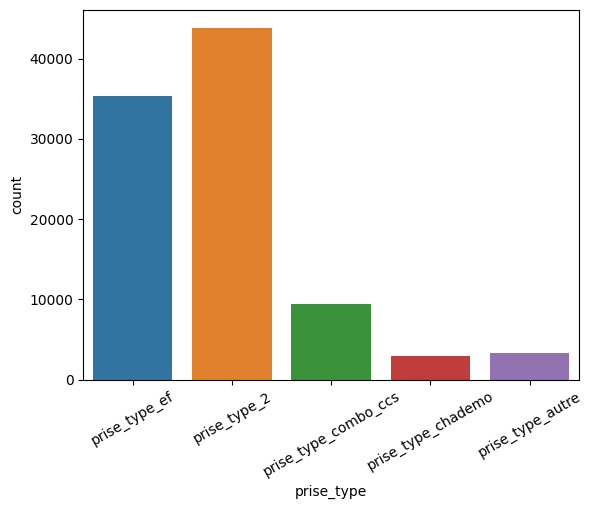

In [112]:
#test1=pd.DataFrame([irve["prise_type_ef"].sum()], columns=["bo"])
prises_list=[["prise_type_ef",irve["prise_type_ef"].sum()],["prise_type_2",irve["prise_type_2"].sum()],["prise_type_combo_ccs",irve["prise_type_combo_ccs"].sum()],["prise_type_chademo",irve["prise_type_chademo"].sum()],["prise_type_autre",irve["prise_type_autre"].sum()]]
prises_df_count=pd.DataFrame(prises_list, columns=["prise_type","count"])
sns.barplot(data=prises_df_count, x="prise_type", y="count", label=True)
prises_df_count
plt.xticks(rotation=30)